<h1 style="font-size:2.75rem;color:white;"> Design Script for a RF Front-End</h1>

# <u> Imports

In [596]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter

# <u> Technology Definitions

In [597]:
L_MIN = 60e-9

# Parameters for TSMC65NM (K = u0*Cox = u0*E0*epsrox/toxm)
V_TN = 0.28615208;   K_N = 244.961e-06; # 0.0184444380*8.854e-12*3.9/2.60e-09
V_TP = 0.43718619;   K_P = 130.808e-06; # 0.0106069150*8.854e-12*3.9/2.80e-09

# Non LDD region source-gate overlap capacitance per unit channel width - CGSO/CGDO (TSMC65NM)
CGSD0_N = 89.18e-12
CGSD0_P = 74.90e-12

# Cox = E0*Er/tox (TSMC65NM)
COX_N = 13.28e-03   # 8.854e-12*3.9/2.60e-09
COX_P = 12.33e-03   # 8.854e-12*3.9/2.80e-09

# Drain/source minimum drawing area
Sd_s = 0.2*1e-06

# Bottom junction capacitance per unit area at zero bias - CJS/CJD (TSMC65NM)
CJ_N   = 1.185e-03;   CJ_P   = 1.068e-03;

# Bottom junction built-in potential - PBS/PBD (TSMC65NM)
PB_N   = 0.700;       PB_P   = 0.700;

# Bottom junction capacitance grating coefficient - MJS/MJD (TSMC65NM)
MJ_N   = 0.310;       MJ_P   = 0.310;

# Isolation-edge sidewall junction capacitance per unit area - CJSWS/CJSWD (TSMC65NM)
CJSW_N = 94.00e-12;   CJSW_P =  76.00e-12;

# Isolation-edge sidewall junction capacitance grading coefficient MJSWS/MJSWD (TSMC65NM)
MJSW_N = 0.080;       MJSW_P = 0.060;

# <u> Available current

In [598]:
battery_spec = 2000     # 2000 mAh
autonomy_spec = 30      # 30 days
node_operation = 0.1    # 10% of the time
active_time = 0.4       # 40% of the time when in operation mode

# calculate the max current consumption of the node in order to meet the autonomy spec
total_current = battery_spec / (autonomy_spec * node_operation / active_time * 24)
print(f"Total current consumption: {total_current:.2f} mA")

total_current = np.floor(total_current)
print(f"Total current consumption: {total_current:.0f} mA")

Total current consumption: 11.11 mA
Total current consumption: 11 mA


In [599]:
# max cap on-chip = 10pF
# max ind on-chip = 50nH

# <u> LNA

In [600]:
L_G, L_1, C_GS1, w_0, R_S, w_T, g_m, W, L, C_ox = sp.symbols('L_G L_1 C_GS1 omega_0 R_S omega_T g_m W L C_ox')

## <u> Equations

In [601]:
eq_1 = sp.Eq(1 / ((L_G + L_1) * (C_GS1)), w_0**2)
display(eq_1)


Eq(1/(C_GS1*(L_1 + L_G)), omega_0**2)

In [602]:
eq_2 = sp.Eq(L_1 * w_T, R_S)
display(eq_2)

Eq(L_1*omega_T, R_S)

In [603]:
eq_3 = sp.Eq(g_m, w_T * C_GS1)
display(eq_3)

Eq(g_m, C_GS1*omega_T)

## <u> Design Variables

In [604]:
 # Define constant values for design    
L_1_value = 1e-9    # Inductance in Henry (example: 1 nH)
L_G_value = 10e-9    # Inductance in Henry (example: 1 nH) - 93.66nH
w_0_value = 2 * np.pi * 2.4e9  # Operating frequency in rad/s (example: 2.4 GHz)

## <u> Design Procedure

### <u> Method 1

#### <u> Cgs1

In [605]:
C_GS1_expression = sp.solve(eq_1, C_GS1)[0]
C_GS1_value = C_GS1_expression.subs({
    L_1: L_1_value,
    L_G: L_G_value,
    w_0: w_0_value
})
display(C_GS1_value)
print(f"C_GS1: {C_GS1_value:.2e} F")


3.99783710709982e-13

C_GS1: 4.00e-13 F


#### <u> ωT

In [606]:
# Transition frequency
w_T_expression = sp.solve(eq_2, w_T)[0]
w_T_value = w_T_expression.subs({
    C_GS1: C_GS1_value,
    L_1: L_1_value,
    R_S: 50
})
display(w_T_value)
print(f"Transition frequency: {w_T_value / (2 * np.pi) / 1e9:.2f} GHz")

50000000000.0000

Transition frequency: 7.96 GHz


#### <u> gm

In [607]:
gm_value = eq_3.rhs.subs(w_T, w_T_value).subs(C_GS1, C_GS1_value)
display(gm_value)
print(f"Transconductance: {gm_value:.2e} S")

0.0199891855354991

Transconductance: 2.00e-2 S


#### <u> Transistor Width analysis

In [608]:
K_N = 244.961e-06
L_min = 60 * 10**-9

L_1 = L_min
W_1 = np.linspace(1e-6, 100e-6, 10)
I_D = np.linspace(1e-3, 10e-3, 100)

In [609]:
# Initialize arrays for gm and fT
g_m_values = np.zeros((len(W_1), len(I_D)))
f_T_values = np.zeros((len(W_1), len(I_D)))

# Calculate gm and fT for each combination of W_1 and I_D
for i, W in enumerate(W_1):
    g_m_values[i, :] = np.sqrt(2 * K_N * (W / L_1) * I_D)
    f_T_values[i, :] = g_m_values[i, :] / (2 * np.pi * C_GS1_value)

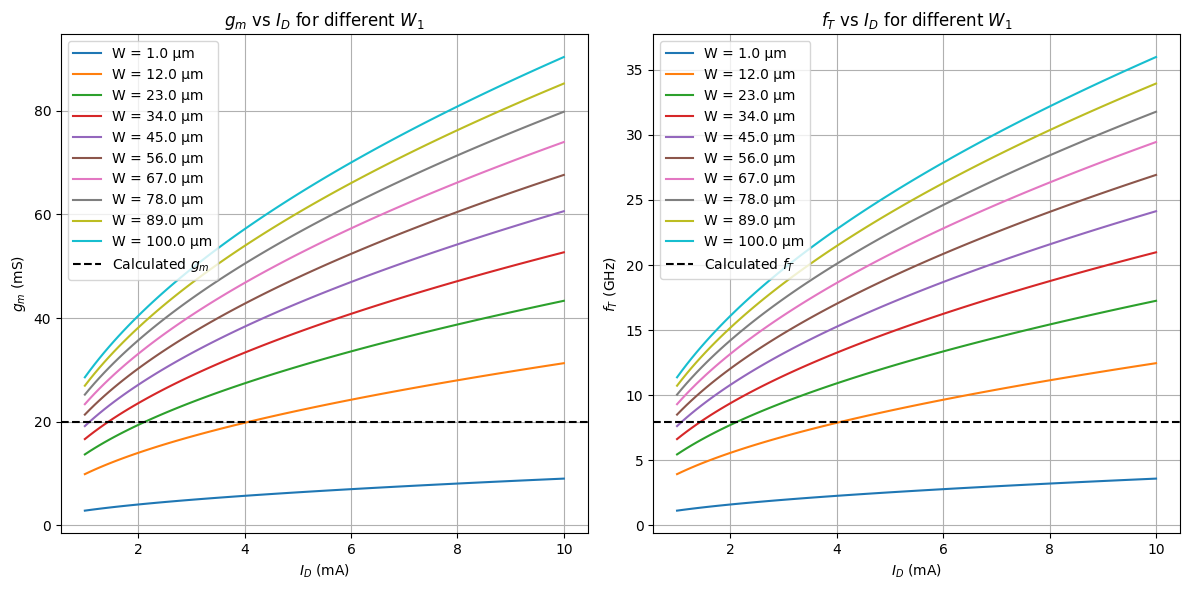

In [610]:
calculated_gm = gm_value
calculated_fT = w_T_value / (2 * np.pi)

# Plot gm and fT as functions of ID for different W_1
plt.figure(figsize=(12, 6))

# gm plot
plt.subplot(1, 2, 1)
for i, W in enumerate(W_1):
    plt.plot(I_D * 1e3, g_m_values[i, :] * 1e3, label=f'W = {W * 1e6:.1f} µm')
plt.axhline(y=calculated_gm * 1e3, color='black', linestyle='--', label=r'Calculated $g_m$')
plt.xlabel(r'$I_D$ (mA)')
plt.ylabel(r'$g_m$ (mS)')
plt.title(r'$g_m$ vs $I_D$ for different $W_1$')
plt.legend()
plt.grid()

# fT plot
plt.subplot(1, 2, 2)
for i, W in enumerate(W_1):
    plt.plot(I_D * 1e3, f_T_values[i, :] * 1e-9, label=f'W = {W * 1e6:.1f} µm')
plt.axhline(y=calculated_fT * 1e-9, color='black', linestyle='--', label=r'Calculated $f_T$')
plt.xlabel(r'$I_D$ (mA)')
plt.ylabel(r'$f_T$ (GHz)')
plt.title(r'$f_T$ vs $I_D$ for different $W_1$')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [611]:
W_value = 34e-6
Id_value = 2.5e-3

C_GS1_intrinsic = 1 * W_value * L_min * COX_N
print(f"Intrinsic capacitance: {C_GS1_intrinsic:.2e} F")

C_GS_extrinsic = C_GS1_value - C_GS1_intrinsic
print(f"Extrinsic capacitance: {C_GS_extrinsic:.2e} F")


Intrinsic capacitance: 2.71e-14 F
Extrinsic capacitance: 3.73e-13 F


In [612]:
# Calculate NF
NF = 1 + calculated_gm * 50 * 1 * (w_0_value / w_T_value)**2

# Display the result
print(f"Noise Figure (NF): {NF:.2f}")

Noise Figure (NF): 1.09


### <u> Method 2